In [1]:
#@title foo
#!pip install transformers==4.1.1 plotnine

In [2]:
import re
import itertools

import numpy as np
import pandas as pd

from IPython.display import HTML
import plotnine
from plotnine import *

import torch
from transformers import AutoModel, AutoTokenizer
from attention_graph_util import *
plotnine.options.figure_size = (12, 12)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
transformer = "distilbert-base-cased"
#transformer = "gpt2"
#transformer = "gpt2-medium"
#transformer = "gpt2-large"
#transformer = "twmkn9/bert-base-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(transformer)
model = AutoModel.from_pretrained(transformer, output_attentions=True, output_hidden_states=True)
model.to(device)
model.eval()
model.zero_grad()


IN PREPARE_COOKIES None
IN PREPARE_COOKIES None
IN PREPARE_COOKIES None
IN PREPARE_COOKIES None
IN PREPARE_COOKIES None
IN PREPARE_COOKIES None
IN PREPARE_COOKIES None
IN PREPARE_COOKIES None
IN PREPARE_COOKIES None
IN PREPARE_COOKIES None


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
sentences = [
    "You will either win or lose the game.",
    "Less is more.",
#    "The quick brown fox jumped over the lazy dog.",
]

# gpt2 doesn't do padding, so invent a padding token
# this one was suggested by the error you get when trying
# to do masking below, but it shouldn't matter as the actual
# tokens get ignored by the attention mask anyway
if transformer in ['gpt2', 'gpt2-medium', 'gpt2-large']:
    tokenizer.pad_token = tokenizer.eos_token

input_dict = tokenizer(sentences, padding=True, return_tensors="pt")
for k, v in input_dict.items():
    input_dict[k] = v.to(device)
print(input_dict)

{'input_ids': tensor([[  101,  1192,  1209,  1719,  1782,  1137,  3857,  1103,  1342,   119,
           102],
        [  101, 13568,  1110,  1167,   119,   102,     0,     0,     0,     0,
             0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]], device='cuda:0')}


In [6]:
input_dict['input_ids'][1]

tensor([  101, 13568,  1110,  1167,   119,   102,     0,     0,     0,     0,
            0], device='cuda:0')

In [7]:
output = model(**input_dict)

In [8]:
att = (
    np.array([
                a.cpu().detach().numpy() 
                    for a in output['attentions']
            ])
        .swapaxes(0,1)
)
print(att.shape)

(2, 6, 12, 11, 11)


#### raw attention
show the attention values for the second token (first word token) of the second sentence. 

I'm using the second sentence because it's shorter so I can cut off the last dimension, as the rest is masked, so all zero

In [9]:
att[1,:,:,1, :6].round(2)

array([[[0.89, 0.03, 0.01, 0.04, 0.04, 0.  ],
        [0.75, 0.08, 0.03, 0.1 , 0.02, 0.02],
        [0.41, 0.07, 0.09, 0.05, 0.11, 0.28],
        [0.01, 0.02, 0.96, 0.01, 0.  , 0.  ],
        [0.69, 0.03, 0.01, 0.03, 0.08, 0.16],
        [0.16, 0.04, 0.29, 0.25, 0.18, 0.07],
        [0.79, 0.08, 0.04, 0.02, 0.02, 0.05],
        [0.37, 0.07, 0.12, 0.22, 0.01, 0.21],
        [0.58, 0.03, 0.08, 0.04, 0.06, 0.21],
        [0.62, 0.02, 0.06, 0.03, 0.08, 0.2 ],
        [0.59, 0.38, 0.  , 0.01, 0.  , 0.01],
        [0.56, 0.05, 0.17, 0.16, 0.05, 0.01]],

       [[0.46, 0.04, 0.04, 0.04, 0.05, 0.38],
        [0.75, 0.08, 0.01, 0.01, 0.06, 0.09],
        [0.33, 0.05, 0.08, 0.13, 0.19, 0.22],
        [0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.23, 0.05, 0.39, 0.18, 0.12, 0.04],
        [0.24, 0.  , 0.  , 0.01, 0.04, 0.71],
        [0.38, 0.01, 0.08, 0.02, 0.13, 0.37],
        [0.31, 0.15, 0.02, 0.11, 0.24, 0.18],
        [0.36, 0.  , 0.09, 0.01, 0.18, 0.36],
        [0.38, 0.05, 0.06, 0.08,

In [26]:
%%time
att = batch_to_flow(att)

(2, 6, 12, 11, 11)
span (6, 12, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
span result (6, 12, 11, 11)
span (6, 12, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
head (6, 11, 11)
span result (6, 12, 11, 11)
(2, 6, 12, 11, 11)
CPU times: user 59.3 s, sys: 19.6 ms, total: 59.4 s
Wall time: 59.3 s


In [11]:
print(att.shape)

(2, 6, 12, 11, 11)


#### rollout adjusted attention

show the same values as above, but after the rollout algorithm

In [12]:
att[1,:,:,1, :6].round(2)

array([[[0.89, 0.03, 0.01, 0.04, 0.04, 0.  ],
        [0.75, 0.08, 0.03, 0.1 , 0.02, 0.02],
        [0.41, 0.07, 0.09, 0.05, 0.11, 0.28],
        [0.01, 0.02, 0.96, 0.01, 0.  , 0.  ],
        [0.69, 0.03, 0.01, 0.03, 0.08, 0.16],
        [0.16, 0.04, 0.29, 0.25, 0.18, 0.07],
        [0.79, 0.08, 0.04, 0.02, 0.02, 0.05],
        [0.37, 0.07, 0.12, 0.22, 0.01, 0.21],
        [0.58, 0.03, 0.08, 0.04, 0.06, 0.21],
        [0.62, 0.02, 0.06, 0.03, 0.08, 0.2 ],
        [0.59, 0.38, 0.  , 0.01, 0.  , 0.01],
        [0.56, 0.05, 0.17, 0.16, 0.05, 0.01]],

       [[0.33, 0.13, 0.08, 0.11, 0.13, 0.21],
        [0.51, 0.1 , 0.07, 0.11, 0.05, 0.15],
        [0.16, 0.21, 0.14, 0.16, 0.22, 0.1 ],
        [0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
        [0.14, 0.18, 0.12, 0.12, 0.27, 0.17],
        [0.74, 0.03, 0.05, 0.05, 0.06, 0.07],
        [0.41, 0.05, 0.04, 0.08, 0.21, 0.21],
        [0.25, 0.13, 0.12, 0.21, 0.04, 0.25],
        [0.29, 0.08, 0.09, 0.08, 0.31, 0.15],
        [0.2 , 0.2 , 0.21, 0.13,

In [13]:
# sort all the attention softmax vectors in descending order
sorted = np.take_along_axis(att, (-att).argsort(), axis=-1)
print(sorted.shape)

(2, 6, 12, 11, 11)


In [14]:
# add them up cumulatively
cum = sorted.cumsum(axis=-1)
print(cum.shape)

(2, 6, 12, 11, 11)


In [15]:
# determine which ones are below 0.9
limit = np.where(cum < 0.9, True, False)
print(limit.shape)

(2, 6, 12, 11, 11)


In [16]:
# count the ones below 0.9; k is that sum + 1
k = limit.sum(axis=-1) + 1
print(k.shape)

(2, 6, 12, 11)


In [17]:
# swap the 'head' and 'sentence' axes so we can more easily apply the attention mask
ks = np.moveaxis(k, [2,1,0],[1,0,2])
print(ks.shape)

(6, 12, 2, 11)


In [18]:
# use the attention mask to flag the padding tokens
att_mask = input_dict['attention_mask'].cpu().detach()
mt = np.ma.MaskedArray(ks, mask = (att_mask == False).expand(ks.shape))

In [19]:
# flatten out the sentences so we're left with just a list of tokens
mr = mt.reshape(ks.shape[:2] + tuple([np.prod(ks.shape[2:])]))
print(mr.shape)

(6, 12, 22)


In [20]:
# find the indices of the token list we're interested in
unmasked = np.flatnonzero(att_mask)

In [21]:
# get the dimensions of the data we want
# layer X head X #tokens
l, h, v = mr[:, :, unmasked].shape
print(l, h, v)

6 12 17


In [22]:
# create a layer/head multiindex
ix = pd.MultiIndex.from_arrays(
    [
        np.repeat(np.arange(l) + 1,h),
        np.tile(np.arange(h) + 1, l)
    ], 
    names=['layer', 'head'])

In [23]:
# finally filter out the padding tokens, put the data in a dataframe,
# and transform it so we get one layer/head/token/k per row
data = (
        pd.DataFrame(mr[:,:,unmasked].reshape((l*h,len(unmasked))), index=ix)
            .reset_index()
            .melt(id_vars=['layer', 'head'])
    )
display(data)

,layer,head,variable,value
0,1,1,0,8
1,1,2,0,7
2,1,3,0,10
3,1,4,0,5
4,1,5,0,2
...,...,...,...,...
1219,6,8,16,5
1220,6,9,16,5
1221,6,10,16,6
1222,6,11,16,4


In [24]:
# calculate the median k per head
avg_k = pd.DataFrame(np.median(mr[:,:,unmasked], axis=-1).flatten(), index=ix, columns=["value"]).reset_index()
display(avg_k)

/home/martijn/miniconda3/envs/hug/lib/python3.6/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.


,layer,head,value
0,1,1,6.0
1,1,2,4.0
2,1,3,8.0
3,1,4,1.0
4,1,5,6.0
...,...,...,...
67,6,8,9.0
68,6,9,10.0
69,6,10,10.0
70,6,11,9.0


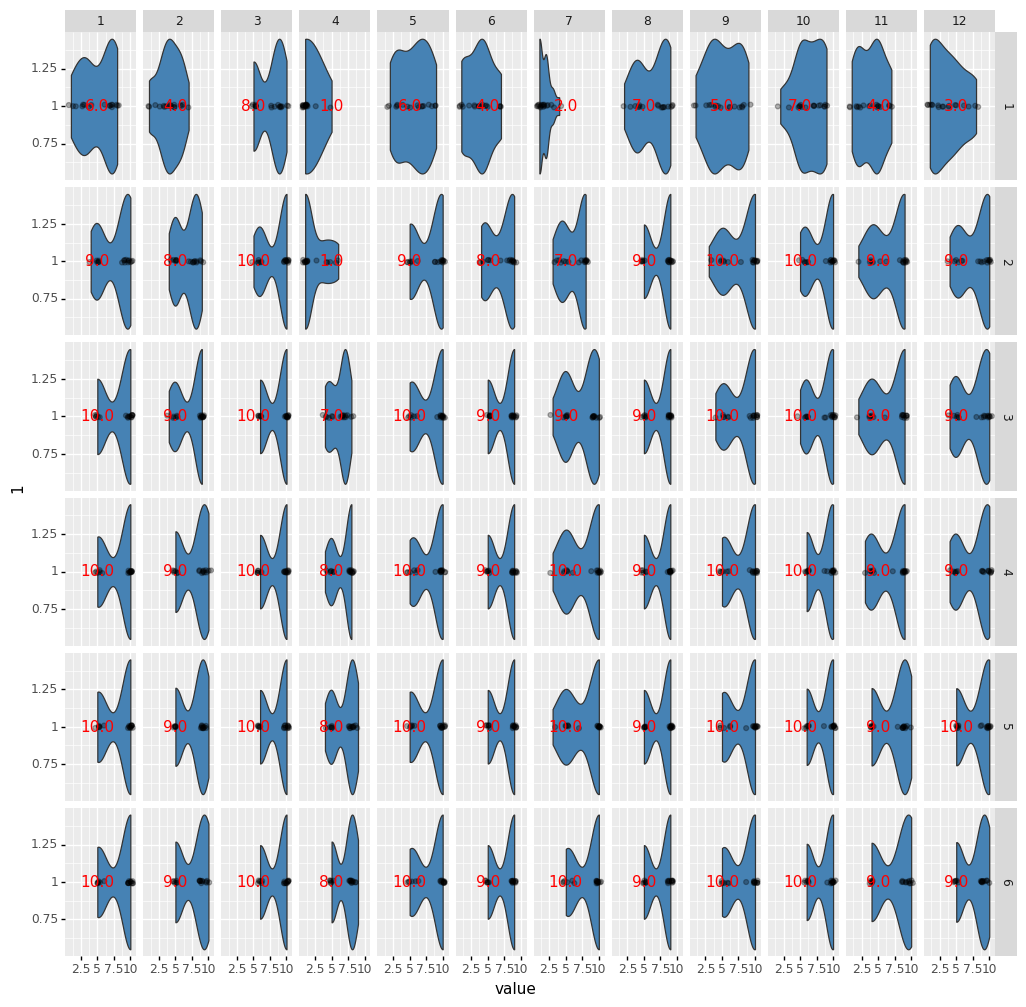

<ggplot: (8776868817377)>

In [25]:
# plot it!
(ggplot(data, aes(1, "value"))  + 
     geom_violin(fill="steelblue") + 
     geom_jitter(width=0.01, alpha=0.3) +
     geom_text(data=avg_k, mapping=aes(x=1, y=5, label="value"), color="red") +
     facet_grid("layer ~ head") + 
     coord_flip()
)